In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
from scipy.stats import ttest_1samp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('public/train.csv')

In [3]:
len(df)

1993574

In [4]:
backup_df = df.copy()

In [5]:
df= backup_df.copy() #

In [6]:
len(df.iloc[0])

113

Trying to figure out the percentile of outliers

In [7]:
percentile_high = []
percentile_low = []
for c in df.columns.values.tolist():
    mean = np.nanmean(df[c])
    std_dev = np.nanstd(df[c])
    z_scores = (df[c] - mean) / std_dev
    percentile_high.append(np.nanpercentile(z_scores, 97))
    percentile_low.append(np.nanpercentile(z_scores, 7))
    
minimum = min(percentile_high)
maximum = max(percentile_high)
print("High ")
print("Minimum:", minimum)
print("Maximum:", maximum)
minimum = min(percentile_low)
maximum = max(percentile_low)
print("Low")
print("Minimum:", minimum)
print("Maximum:", maximum)

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


High 
Minimum: -0.05080129031598146
Maximum: 2.7096491386098567
Low
Minimum: -2.5098363534132138
Maximum: 0.23830876709077303


What we are doing here is calulating z_scores for each column and each datapoints. Then we take the 97 percentile of z_scores for each column. For example, if the percentile_97 value for a column is 2, it means that 97% of the data points are under 2 standard deviations away from the mean. 
Since the maximum value of 97 percentile of zscores for any column is only 2.7 times away from the standard deviation, it seems, we don't have any major outliers.
Similarly the low of percentile for 7% is -2.5 which is ok.

Getting rid of outliers values with nan. We will treat the values that are far away from the mean of the data as null. This will be later filled with new points before training.

In [8]:
changenumber = 0
for c in df.columns.values.tolist():
    mean = np.nanmean(df[c])
    std_dev = np.nanstd(df[c])
    z_scores = (df[c] - mean) / std_dev
    
    # Find indices of data points with z-scores greater than 2.8 or less than -2.8
    indices = np.where((z_scores > 2.8) | (z_scores < -2.8))
    
    # Set the values at those indices to 'nan'
    df[c] = df[c].mask((z_scores > 2.8) | (z_scores < -2.8), np.nan)
    changenumber = changenumber+len(indices[0])
print(changenumber)

2332833


In total we made 2332833 changes. Since we have 2 million * 113 datapoints, this value while may seem big, in reality is not so significant.

In [9]:
for c in df.columns.values.tolist():
    if df[c].isnull().sum() > 50000:
        print(c)
        print(df[c].isnull().sum())

fact_latitude
93562
topography_bathymetry
55364
climate_pressure
52903
cmc_0_0_7_2
54091
cmc_0_1_65_0
54276
cmc_0_3_0_0
50250
cmc_0_3_0_0_next
50239
gfs_r_velocity
52862
wrf_available
107133
wrf_t2_next
119408
wrf_psfc
157570
wrf_rh2
111936
wrf_wind_u
133803
wrf_wind_v
132881
wrf_rain
130521
wrf_snow
116717
wrf_graupel
110323
wrf_t2_interpolated
119437
wrf_t2_grad
147811
cmc_0_1_65_0_next
54316
gfs_total_clouds_cover_low_grad
75720


fact_latitude
93562


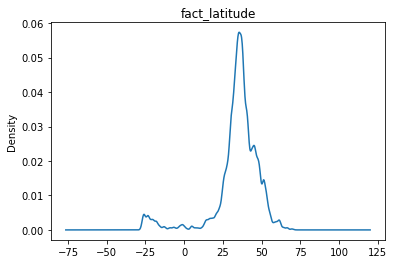

topography_bathymetry
55364


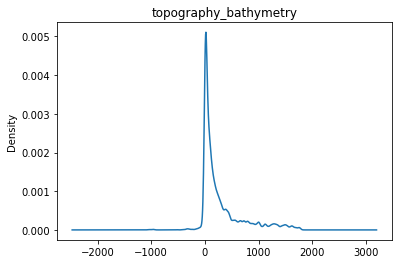

climate_pressure
52903


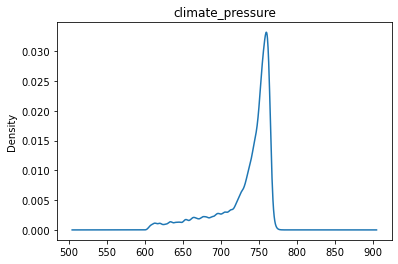

cmc_0_0_7_2
54091


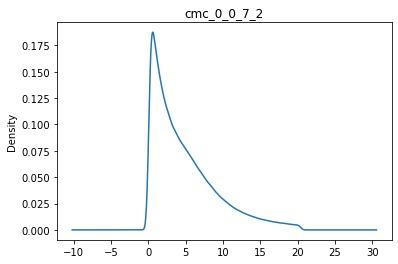

cmc_0_1_65_0
54276


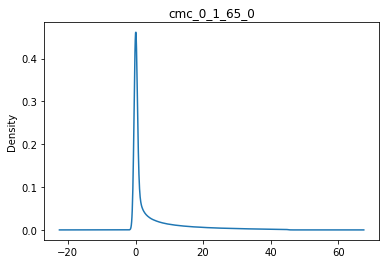

cmc_0_3_0_0
50250


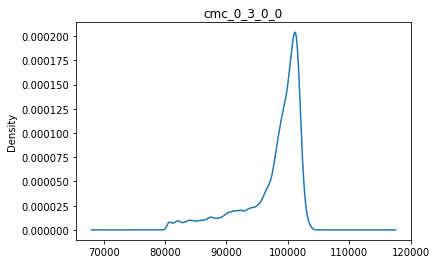

cmc_0_3_0_0_next
50239


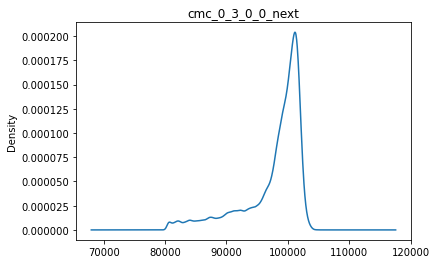

gfs_r_velocity
52862


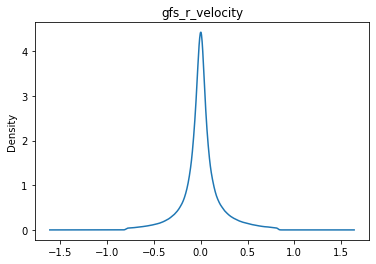

wrf_available
107133


LinAlgError: singular matrix

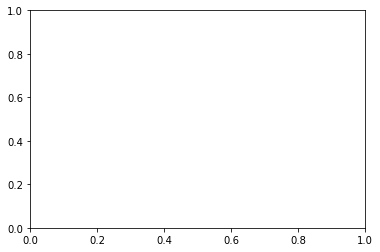

In [16]:
for c in df.columns.values.tolist():
    if df[c].isnull().sum() > 50000:
        print(c)
        print(df[c].isnull().sum())
        df[c].plot(kind='kde')
        plt.title(c)# Set the title of the plot as the feature name
        plt.show()  

##### Correlation Check
We will check the correlation of different features to get an idea, what kind of dimensanatily reduction method can be utilised for this dataset.

In [10]:
correlation_matrix = df.corr()

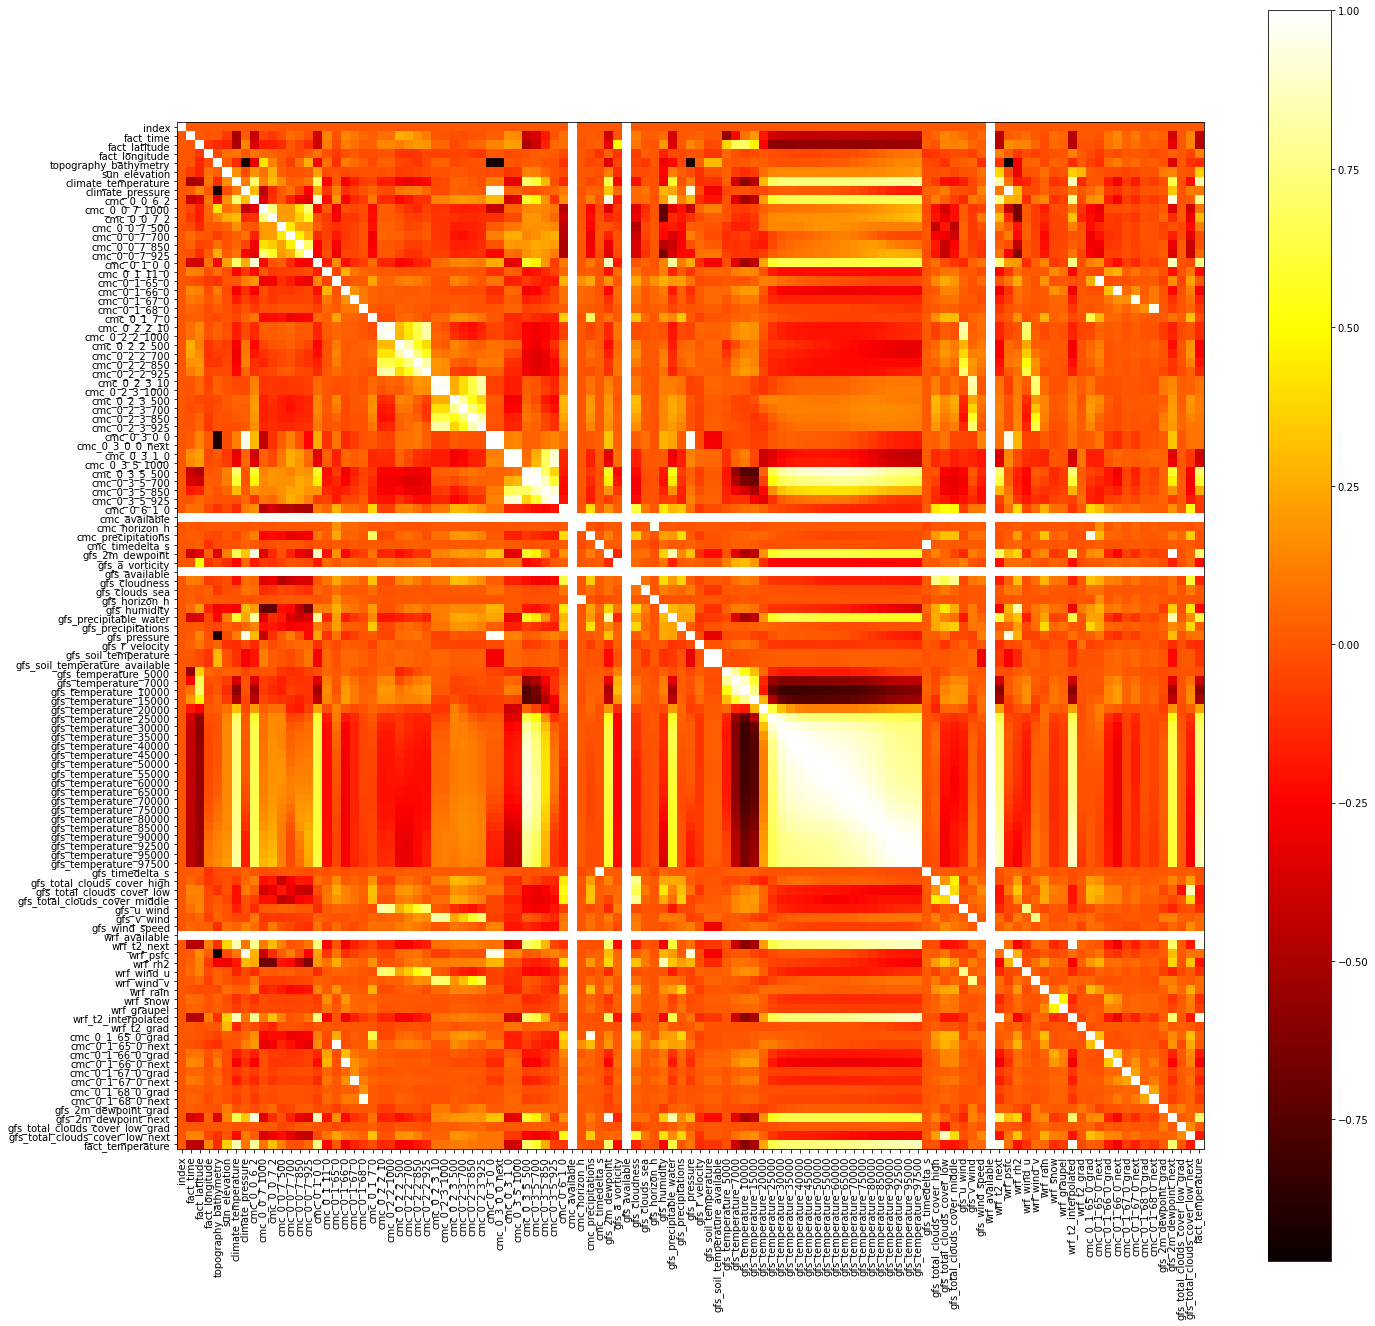

In [11]:
fig, ax = plt.subplots(figsize=(23, 23))
im = ax.imshow(correlation_matrix, cmap='hot', interpolation='nearest')

plt.colorbar(im)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

plt.show()

In [12]:
correlation_matrix

,index,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,...,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next,fact_temperature
index,1.000000,-0.000912,-0.001086,0.000075,-0.001191,-0.000350,0.000861,0.001106,0.001637,-0.001023,...,-0.000784,0.000113,-0.000323,0.000519,0.000976,-0.000185,0.001211,0.000089,0.000388,0.000996
fact_time,-0.000912,1.000000,0.001735,-0.004638,-0.000269,-0.084643,-0.503017,0.015263,-0.404525,-0.042625,...,0.147686,0.043338,0.100966,0.020881,0.047727,0.022033,-0.386148,0.003974,0.138150,-0.442550
fact_latitude,-0.001086,0.001735,1.000000,-0.090121,-0.137743,-0.151550,-0.492437,0.138282,-0.349584,-0.165415,...,0.129342,0.038424,0.079775,0.013763,0.026324,0.002486,-0.321709,0.000562,0.132911,-0.469003
fact_longitude,0.000075,-0.004638,-0.090121,1.000000,-0.036656,0.076602,0.088084,-0.001333,0.089410,0.046046,...,-0.025386,0.000136,0.000564,-0.009109,-0.029106,-0.013361,0.032551,-0.001049,-0.047720,0.140986
topography_bathymetry,-0.001191,-0.000269,-0.137743,-0.036656,1.000000,0.021478,-0.127873,-0.941694,-0.322212,0.422127,...,0.108484,0.030602,0.063757,0.009232,0.015092,-0.010860,-0.343092,0.002239,-0.103524,-0.129612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gfs_2m_dewpoint_grad,-0.000185,0.022033,0.002486,-0.013361,-0.010860,0.109692,-0.013841,0.012505,-0.034526,0.021346,...,-0.004694,0.016819,0.002130,0.002937,0.005376,1.000000,0.072027,0.119300,0.033536,0.016259
gfs_2m_dewpoint_next,0.001211,-0.386148,-0.321709,0.032551,-0.343092,0.136238,0.652435,0.331438,0.931937,-0.341503,...,-0.242801,-0.057375,-0.119219,-0.034150,-0.070848,0.072027,1.000000,0.007300,0.051799,0.721876
gfs_total_clouds_cover_low_grad,0.000089,0.003974,0.000562,-0.001049,0.002239,0.009508,-0.009634,-0.002055,-0.010789,0.009181,...,-0.007643,0.014671,0.000259,0.003809,-0.003383,0.119300,0.007300,1.000000,0.152719,0.003080
gfs_total_clouds_cover_low_next,0.000388,0.138150,0.132911,-0.047720,-0.103524,-0.007260,-0.220958,0.110461,0.017514,-0.367195,...,0.129289,0.037825,0.082417,0.035267,0.042902,0.033536,0.051799,0.152719,1.000000,-0.183737


In [13]:
def fill_na_mean(df):
    for c in df.columns.values.tolist():
        if df[c].isnull().any :
            mean_c = df[c].mean()
            df[c] = df[c].fillna(mean_c)
    return df

In [14]:
def fill_na_median(df):
    for c in df.columns.values.tolist():
        if df[c].isnull().any :
            median_c = df[c].median()
            df[c] = df[c].fillna(median_c)
    return df

In [15]:
filled_median_df = fill_na_median(df)
filled_mean_df = fill_na_mean(df)

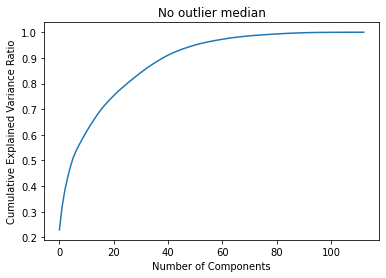

In [34]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(filled_median_df)
pca = PCA().fit(scaled_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('No outlier median')
plt.show()
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.8) + 1
#the number determines the threshold 
PCA_transformed_median = pca.transform(scaled_df)[:, :n_components]

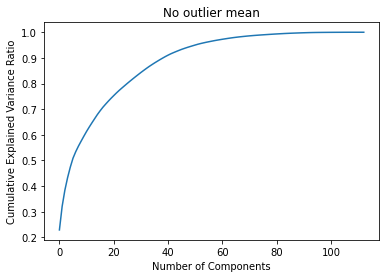

In [36]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(filled_mean_df)
pca = PCA().fit(scaled_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('No outlier mean')
plt.show()

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.8) + 1
#the number determines the threshold 
PCA_transformed_mean = pca.transform(scaled_df)[:, :n_components]